In [1]:
#pip install pandas numpy scikit-learn matplotlib yfinance tensorflow scikeras

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from scikeras.wrappers import KerasRegressor

from graphing import graph_normal, show_results
from get_data import get_apple_stock_split

In [3]:
# Download Apple stock data
data = yf.download("AAPL", start="2015-01-01", end="2023-01-01")
data = data.drop(columns=['High', 'Low', 'Open', 'Volume'])

#simple moving averages
data['SMA_10'] = data['Close'].rolling(window=10).mean()
data['SMA_50'] = data['Close'].rolling(window=50).mean()

# set target as difference from future days
PREDICTED_DAYS = 3
targets = {f'target_{i}': data['Close'].diff(periods=-i) for i in range(1, PREDICTED_DAYS + 1)}
data = data.assign(**targets)  #** means dictionary unpacking

#set features as difference from previous days 
DAYS_LAG = 5
lags = {f'lag_{i}': data['Close'].diff(i) for i in range(1, DAYS_LAG + 1)}
data = data.assign(**lags)

# Drop rows with missing values
data.dropna(inplace=True)

#print(data.head())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [4]:
#scalers
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

TARGETS = data[[f'target_{i}' for i in range(1, PREDICTED_DAYS + 1)]]

X = data[["Close"] + ["SMA_10"] + ["SMA_50"] + [f'lag_{i}' for i in range(1, DAYS_LAG + 1)]]
Y = TARGETS[['target_1']]

print(X.head())
print(Y.head())

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=3)

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

Y_train = scaler_Y.fit_transform(Y_train)
Y_test = scaler_Y.transform(Y_test)


Price           Close     SMA_10     SMA_50     lag_1     lag_2     lag_3  \
Ticker           AAPL                                                       
Date                                                                        
2015-03-16  27.904795  28.089932  26.677913  0.303728  0.111662  0.605221   
2015-03-17  28.371553  28.038120  26.758936  0.466759  0.770487  0.578421   
2015-03-18  28.690905  28.036557  26.860048  0.319351  0.786110  1.089838   
2015-03-19  28.474274  28.060899  26.956784 -0.216631  0.102720  0.569479   
2015-03-20  28.116953  28.045266  27.039744 -0.357321 -0.573952 -0.254601   

Price          lag_4     lag_5  
Ticker                          
Date                            
2015-03-16  0.098270 -0.489092  
2015-03-17  1.071980  0.565029  
2015-03-18  0.897772  1.391331  
2015-03-19  0.873207  0.681141  
2015-03-20  0.212158  0.515886  
Price       target_1
Ticker              
Date                
2015-03-16 -0.466759
2015-03-17 -0.319351
2015-03-18  0.

In [5]:
#repeatable way to create the model 
def create_ann(neurons=32, activation='relu', optimizer='admn'):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))  #input structure
    model.add(Dense(neurons, activation=activation)) # hidden layer
    model.add(Dense(1)) #output
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    return model

<h1> GridSearch setup </h1>

In [6]:
# #define model parameters and create model
param_grid = {
    'model__neurons': [16, 32, 64, 128],
    'model__activation': ['relu', 'tanh', 'sigmoid'],
    'model__optimizer': ['adam', 'sgd'],
    'batch_size': [16, 32, 64],
    'epochs': [50, 100]
}

In [7]:
#training
model = KerasRegressor(model=create_ann, verbose=0) #keras regressor is a wrapper to us scikit learn gid search

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,                       # cross-validation
    scoring='neg_mean_squared_error',# Use mae as scoring
    verbose=100,
    n_jobs=-1                   # Use all available cores
)

# Perform grid search on training data
grid_search.fit(X_train, Y_train)

results_df = pd.DataFrame(grid_search.cv_results_)


Fitting 3 folds for each of 144 candidates, totalling 432 fits


C:\Users\kenan\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [8]:
results_df = pd.DataFrame(grid_search.cv_results_).sort_values(by='mean_test_score', ascending=False)
for i, row in results_df.iterrows():
    print(f"Rank {row['rank_test_score']}:")
    print(f"Parameters: {row['params']}")
    print(f"Mean Test Score: {row['mean_test_score']:.4f}")
    print(f"Std Dev of Test Score: {row['std_test_score']:.4f}")
    print("-" * 30)    

Rank 1:
Parameters: {'batch_size': 32, 'epochs': 100, 'model__activation': 'relu', 'model__neurons': 128, 'model__optimizer': 'sgd'}
Mean Test Score: -0.0065
Std Dev of Test Score: 0.0006
------------------------------
Rank 2:
Parameters: {'batch_size': 16, 'epochs': 100, 'model__activation': 'sigmoid', 'model__neurons': 16, 'model__optimizer': 'sgd'}
Mean Test Score: -0.0065
Std Dev of Test Score: 0.0007
------------------------------
Rank 3:
Parameters: {'batch_size': 32, 'epochs': 50, 'model__activation': 'sigmoid', 'model__neurons': 128, 'model__optimizer': 'adam'}
Mean Test Score: -0.0066
Std Dev of Test Score: 0.0006
------------------------------
Rank 4:
Parameters: {'batch_size': 32, 'epochs': 50, 'model__activation': 'sigmoid', 'model__neurons': 64, 'model__optimizer': 'adam'}
Mean Test Score: -0.0066
Std Dev of Test Score: 0.0007
------------------------------
Rank 5:
Parameters: {'batch_size': 16, 'epochs': 50, 'model__activation': 'sigmoid', 'model__neurons': 64, 'model__op

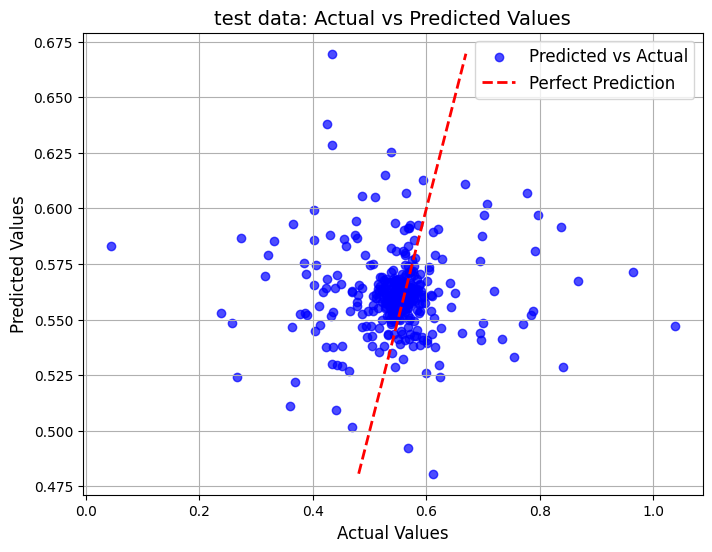

test data  MAE: 0.05332462546850265
test data  RMSE: 0.09139054416947959


In [9]:
# use best model to predict more days
final_model = grid_search.best_estimator_

# Predict on test data
final_predictions = final_model.predict(X_test)



# Evaluate the final model
mae = mean_absolute_error(Y_test, final_predictions)
mse = mean_squared_error(Y_test, final_predictions)
rmse = np.sqrt(mse)

graph_normal(final_predictions,Y_test, "test data")